In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb #xgboost model

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary

In [4]:
plt.rcParams["figure.figsize"] = [16,9]

Error metric: Symmetric Mean Absolute Percentage Error. Common forecasting error metric used across kaggle competitions.

In [5]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [6]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

## XGBoost Model
General xgboost model

In [7]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

## ARIMA Model

## LSTM Nnet Model

## Data Exporation

## Retrieve Data

In [8]:
df = pd.read_csv('C:/Users/conan/iCloudDrive/Projects/volume_pred/data/' +'train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [10]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

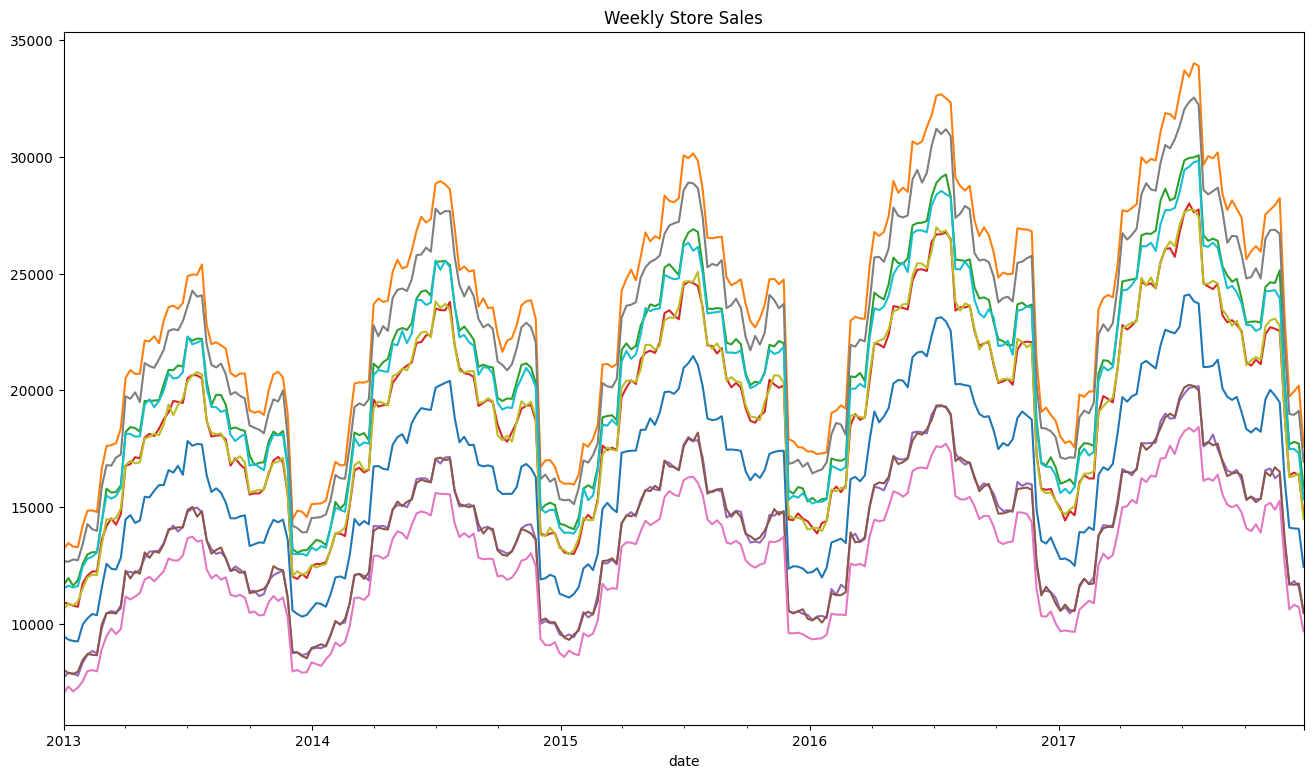

In [11]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

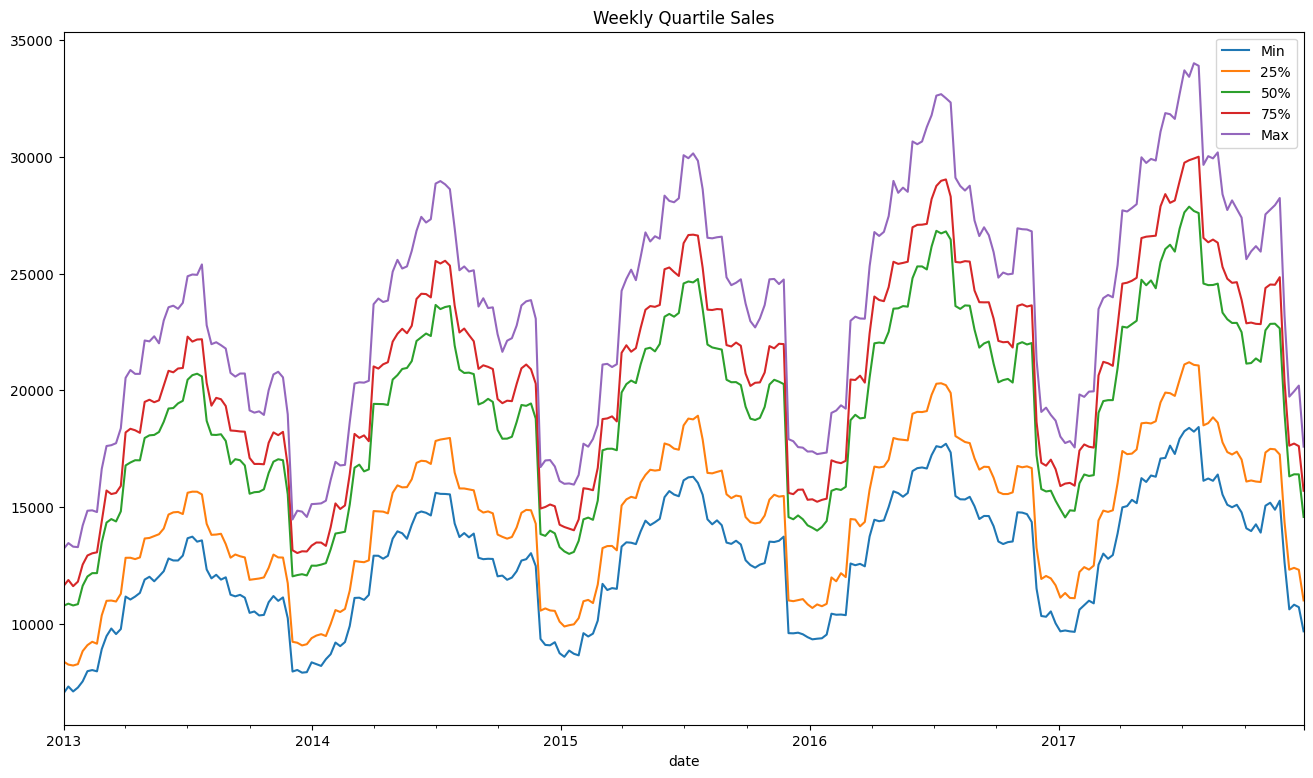

In [12]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

In [14]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


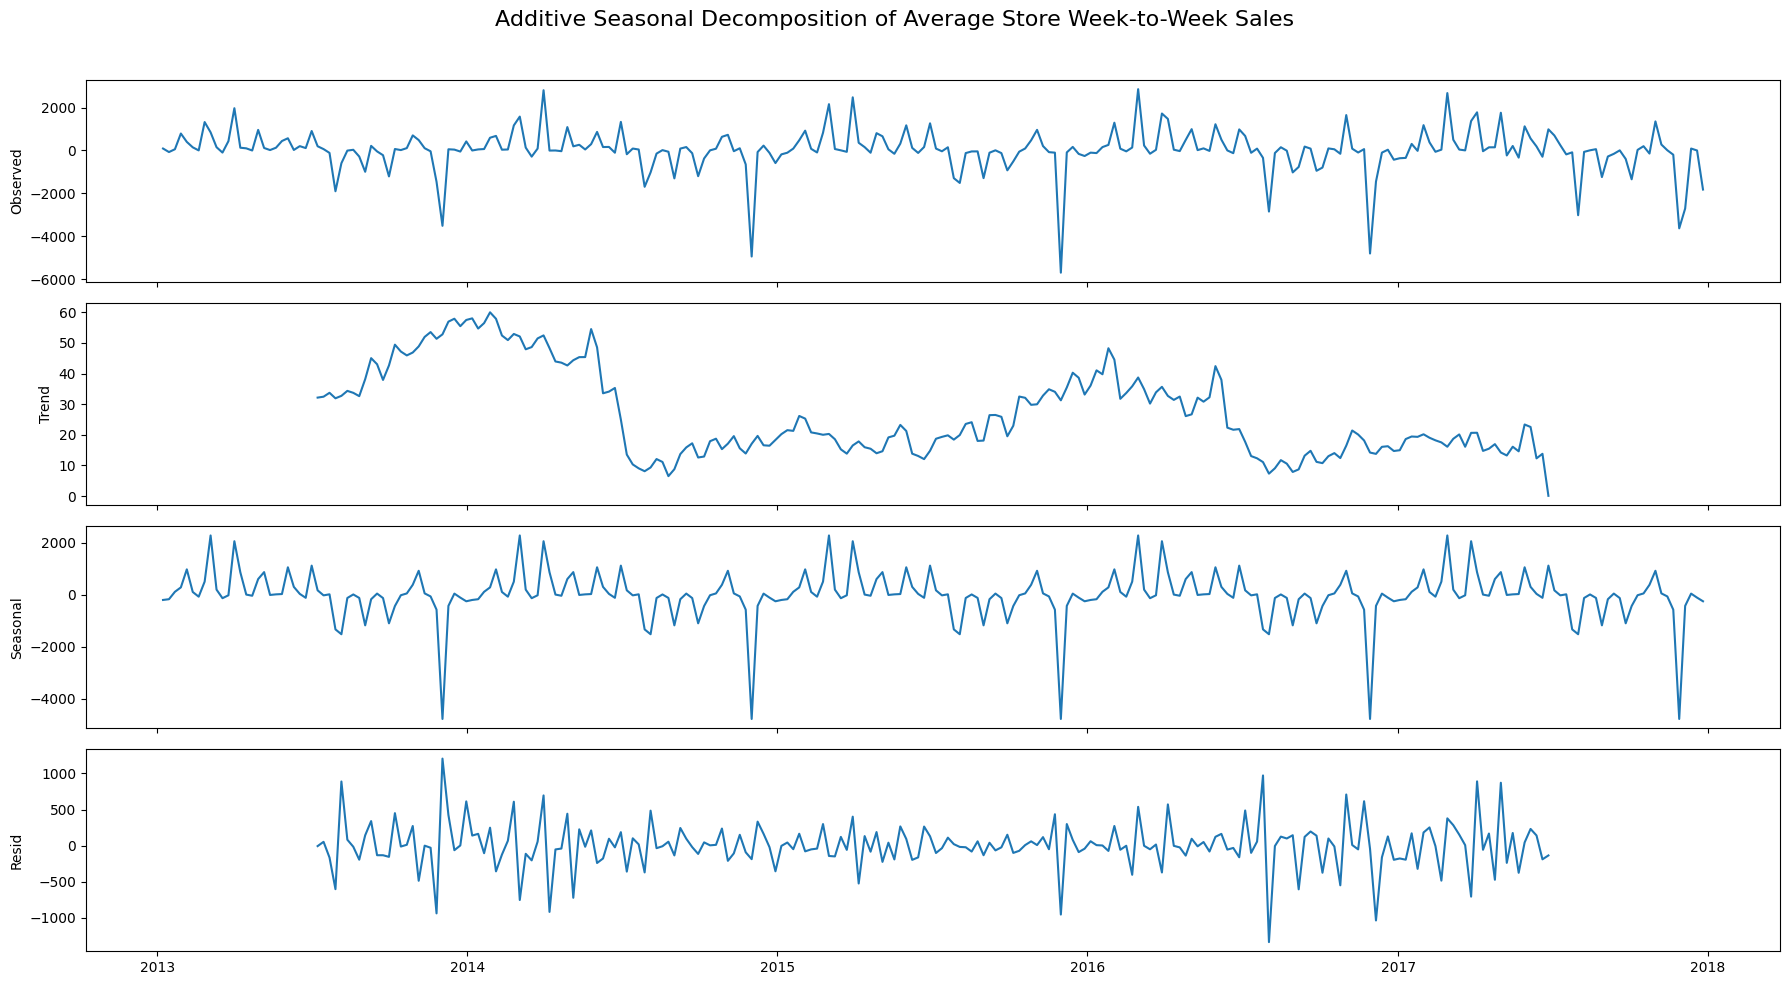

In [ ]:
series = store_qtr['50%'].diff().iloc[1:]
series.name = 'Observed'

# Decompose
decomp = seasonal_decompose(series, model='additive')

# Plot
fig, axs = plt.subplots(4, 1, figsize=(18, 10), sharex=True)
titles = ['Observed', 'Trend', 'Seasonal', 'Resid']
components = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]

for ax, title, comp in zip(axs, titles, components):
    ax.plot(comp)
    ax.set_ylabel(title)

fig.suptitle('Additive Seasonal Decomposition of Average Store Week-to-Week Sales', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [22]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...   
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...   
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...   
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...   
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...   
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...   
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...   
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...   
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...   
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...   
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...   
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...   
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]